In [27]:
import numpy as np
import pickle
import networkx as nx
import netgraph
import matplotlib.pylab as plt
import os
from tqdm import tqdm

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler
from Qommunity.samplers.regular.dqm_sampler import DQMSampler
#from Qommunity.samplers.regular.bayan_sampler import BayanSampler

from Qommunity.searchers.community_searcher.community_searcher import CommunitySearcher
from Qommunity.searchers.hierarchical_community_searcher import HierarchicalCommunitySearcher

from iterative_searcher.iterative_searcher import IterativeSearcher

type_net = 'Karate'#'Power-law' #
num_runs = 20
resolutions = np.array([0.29,0.57,0.86,1.00,1.14,1.43,1.71,2.0,2.29,2.57])

if type_net == 'Karate':
    K = nx.karate_club_graph()
    os.makedirs(f"./Resolution-{type_net}", exist_ok=True)
    n = len(K.nodes())
elif type_net == 'Power-law':
    n, m, p = 10, 1, .1
    os.makedirs(f"./Resolution-{type_net}", exist_ok=True)
    try:
        K = pickle.load(open(f"./Resolution-{type_net}/graph_n={n}_m={m}_p{p}.pickle", 'rb'))
        print("Graph loaded --> You can reuse already calculated solutions")
    except:
        K = nx.powerlaw_cluster_graph(n=n, m=m, p=p)
        pickle.dump(K, open(f"./Resolution-{type_net}/graph_n={n}_m={m}_p{p}.pickle", 'wb'))
        print("Graph generated --> Results should not be loaded now but calculated from scratch")
else:
    raise ValueError("Network not implemented!")


In [28]:
### ADVANTAGE ANNEALING ###
adv_modularities = np.zeros((resolutions.shape[0],))
adv_communities = np.empty(shape=(resolutions.shape[0],), dtype=object)
adv_times_elapsed = np.zeros((resolutions.shape[0],))

for i, resolution in enumerate(resolutions):
    try:
        adv_modularities[i] = np.load(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_modularities.npy")
        adv_communities[i] = np.load(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_communities.npy", allow_pickle=True)[0]
        adv_times_elapsed[i] = np.load(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_times.npy")
        print(f"Reasults loaded for gamma = {resolution}")

    except:                
        adv_sampler = AdvantageSampler(K, resolution=resolution, num_reads=100, use_clique_embedding=True)
        adv_searcher = HierarchicalCommunitySearcher(adv_sampler)
        adv_iterative = IterativeSearcher(adv_searcher)
        cs_all, mod_all, ts_all = adv_iterative.run(num_runs=num_runs, save_results=False)

        # Only the community with the highest modularity
        adv_communities[i] = cs_all[mod_all.argmax()]
        adv_modularities[i] = mod_all.max()
        adv_times_elapsed[i] = ts_all[mod_all.argmax()]

        np.save(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_modularities.npy", adv_modularities[i])
        tmp = np.empty((1,), dtype=object)
        tmp[0] = adv_communities[i]
        np.save(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_communities.npy", tmp, allow_pickle=True)
        np.save(f"./Resolution-{type_net}/solver-adv_runs-{num_runs}_gamma-{resolution}_n-{n}_times.npy", adv_times_elapsed[i])
        break

Reasults loaded for gamma = 0.29
Reasults loaded for gamma = 0.57
Reasults loaded for gamma = 0.86
Reasults loaded for gamma = 1.0
Reasults loaded for gamma = 1.14
Reasults loaded for gamma = 1.43
Reasults loaded for gamma = 1.71
Reasults loaded for gamma = 2.0
Reasults loaded for gamma = 2.29
Reasults loaded for gamma = 2.57


In [29]:
### LOUVAIN ###
try:
    louv_modularities = np.load(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_modularities.npy")
    louv_communities = np.load(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_communities.npy", allow_pickle=True)
    louv_times_elapsed = np.load(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_times.npy")
    print(f"Reasults loaded")

except:
    louv_modularities = np.zeros((resolutions.shape[0],))
    louv_communities = np.zeros((resolutions.shape[0],), dtype=object)
    louv_times_elapsed = np.zeros((resolutions.shape[0],))
    
    for i, resolution in enumerate(resolutions):
        louv_sampler = LouvainSampler(K, resolution=resolution)
        louv_searcher = CommunitySearcher(louv_sampler)
        louv_iterative = IterativeSearcher(louv_searcher)
        cs_all, mod_all, ts_all = louv_iterative.run(num_runs=num_runs, save_results=False)

        # Only the community with the highest modularity
        louv_communities[i] = cs_all[mod_all.argmax()]
        louv_modularities[i] = mod_all.max()
        louv_times_elapsed[i] = ts_all[mod_all.argmax()]

    np.save(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_modularities.npy", louv_modularities)
    np.save(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_communities.npy", louv_communities, allow_pickle=True)
    np.save(f"./Resolution-{type_net}/solver-louv_runs-{num_runs}_n-{n}_times.npy", louv_times_elapsed)

Reasults loaded


In [30]:
### BAYAN ###

### Modularities and time as a function of the resolution

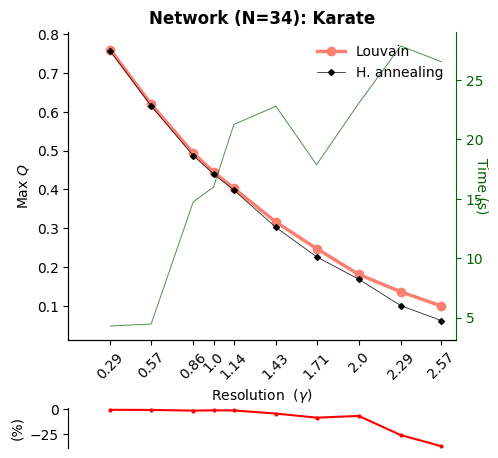

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Temporary patch --> Once the real fix is done in Qommunity, save the values and delete
lm = np.array([nx.community.modularity(K,c,resolution=g) for c,g in zip(louv_communities,resolutions)])
am = np.array([nx.community.modularity(K,c,resolution=g) for c,g in zip(adv_communities,resolutions)])
compare = 100 *(am-lm)/lm

ax.plot(resolutions,lm,"-o",label="Louvain",linewidth=2.5,color="salmon")
ax.plot(resolutions, am, "-D", label="H. annealing", linewidth=0.5, color="black", markersize=3)

ax.legend(frameon=False)
ax.spines[["top", "right"]].set_visible(False)
ax.set_title(f"Network (N={n}): {type_net}", fontweight='bold')
ax.set_xlabel("Resolution  ("+r'$\gamma$'+")")
ax.set_ylabel("Max "+r'$Q$')
ax.set_xlim([0, 2.57+.1])
ax.set_ylim([min(am)-.05, max(am)+.05])
ax.set_xticks(resolutions)
ax.set_xticklabels(resolutions, rotation=45)

pp = .125
ax_inset = fig.add_axes([pp,-.16,.9-pp,0.1])
ax_inset.spines[["top","bottom","right"]].set_visible(False)
ax_inset.plot(resolutions, np.where(compare<0, compare, np.nan), '-o', color='red', markersize=2)
ax_inset.plot(resolutions, np.where(compare==0, compare, np.nan), '-o', color='black', markersize=2)
ax_inset.plot(resolutions, np.where(compare>0, compare, np.nan), '-o', color='blue', markersize=2)
ax_inset.set_ylabel("(%)")
ax_inset.set_xticks(resolutions)
ax_inset.set_xlim([0, 2.57+.1])
ax_inset.set_xticks([])

ax_bis = ax.twinx()
ax_bis.spines[["top"]].set_visible(False)
ax_bis.plot(resolutions,adv_times_elapsed,linewidth=.7,color="darkgreen",alpha=.7)
ax_bis.set_ylabel("Time (s)", rotation=270)
ax_bis.spines['right'].set_color('darkgreen')
ax_bis.yaxis.label.set_color('darkgreen')
ax_bis.tick_params(axis='y', colors='darkgreen')

plt.savefig(f"./Resolution-{type_net}/modularities_n-{n}.svg", format='svg', dpi=300)

### Overlap between the solutions

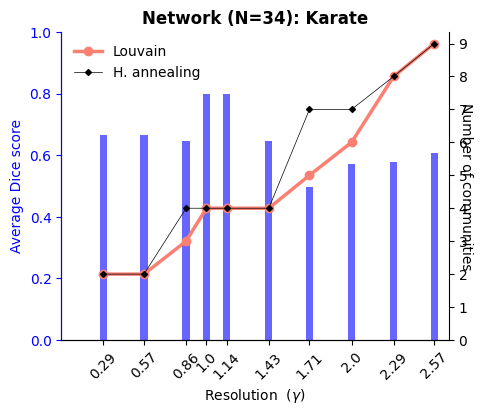

In [32]:
# Overlap between advantage and leiden solutions
dice_louv_adv = np.empty(shape=(len(resolutions), ), dtype=object)
dice_louv_adv_mean = np.zeros((len(resolutions),))
N_comms = np.zeros((len(resolutions),2))

for i, _ in enumerate(resolutions):
    dice_louv_adv[i] = np.zeros((len(louv_communities[i]), len(adv_communities[i])))
    # Number of communities
    N_comms[i,:] = [len(louv_communities[i]),len(adv_communities[i])]
    for ii, c_louv in enumerate(louv_communities[i]):
        for jj, c_adv in enumerate(adv_communities[i]):
            # Dice score
            intersection = set(c_louv).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_louv))+len(set(c_adv)))
            dice_louv_adv[i][ii,jj] = np.where(dice==0, np.nan, dice)
    dice_louv_adv_mean[i] = np.nanmean(dice_louv_adv[i])

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

#ax.plot(resolutions,dice_louv_adv_mean, linewidth=.8, alpha=1, color="Blue")
ax.bar(resolutions,dice_louv_adv_mean, width=0.05, alpha=0.6, color="Blue")

ax.spines[["top", "right"]].set_visible(False)
ax.set_title(f"Network (N={n}): {type_net}", fontweight='bold')
ax.set_xlabel("Resolution  ("+r'$\gamma$'+")")
ax.set_ylabel("Average Dice score")
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax.set_xlim([0, 2.57+.1])
ax.set_ylim([0, 1])
ax.set_xticks(resolutions)
ax.set_xticklabels(resolutions, rotation=45)

ax_bis = ax.twinx()
ax_bis.spines[["top"]].set_visible(False)
ax_bis.spines['left'].set_color('blue')
ax_bis.plot(resolutions,N_comms[:,0],"-o",label="Louvain",linewidth=2.5,color="salmon")
ax_bis.plot(resolutions, N_comms[:,1], "-D", label="H. annealing", linewidth=0.5, color="black", markersize=3)
ax_bis.set_ylabel("Number of communities", rotation=270)
ax_bis.set_yticks(range(0,int(max(N_comms[-1,:]))+1))
ax_bis.legend(frameon=False)

plt.savefig(f"./Resolution-{type_net}/communities_n-{n}.svg", format='svg', dpi=300)

### Behavior of the annealer as a function of the entropy of the solution

This part is not going to work in networks with more tha 20-30 nodes. It relies on exact calculations, which grow exponentially with the number of nodes.

In [33]:
import itertools

try:
    entropy = np.load(f"./Resolution-{type_net}/entropy_runs-{num_runs}_n-{n}.npy")
except:
    entropy = np.zeros((len(resolutions),2))
    for i, gamma in enumerate(resolutions):
        # We consider that the number of qubits in the solutions coincides with the number of qubits of the ground state
        nc = len(louv_communities[i]) # adv_communities[i]
        states = []
        mods = []
        # We iterate over all possibilities
        for x in itertools.product(range(nc), repeat=n):
            states.append(x)
            # nc number of communities
            cs = [set() for _ in range(nc)]
            # assign each node to the corresponding community
            for j in range(n):
                id = x[j]
                cs[id].add(j)
            # compute the modularity of each state - with corresponding modularity
            mods.append(nx.community.modularity(K, cs, resolution=gamma))
        # find the ground state
        a, b = np.unique(mods, return_counts=True)
        # compute the entropy as the base 2 logarithm
        entropy[i,:] = [a.max(), np.log2(b[a.argmax()])]
    np.save(f"./Resolution-{type_net}/entropy_runs-{num_runs}_n-{n}.npy", entropy)

KeyboardInterrupt: 

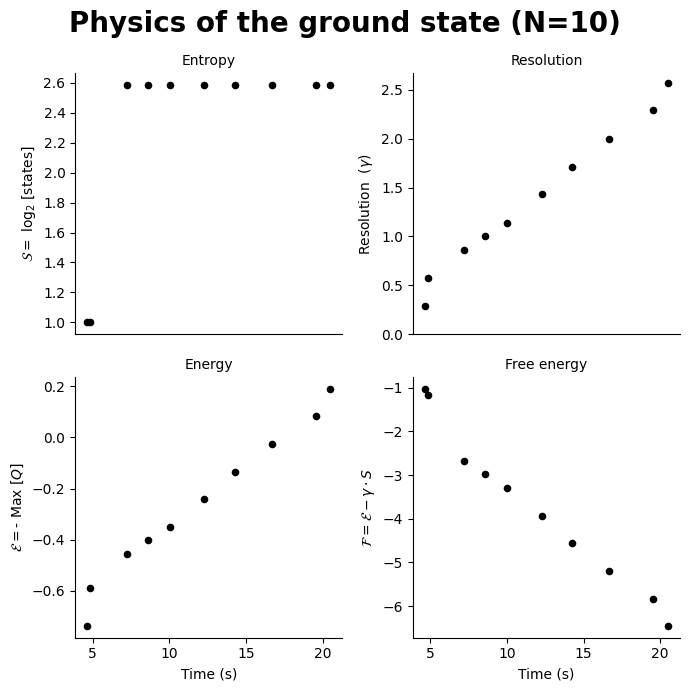

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(7,7))

ax1.scatter(adv_times_elapsed,entropy[:,1], color="black", s=20)
ax1.set_xticks([])
ax1.spines[["top","right"]].set_visible(False)
ax1.set_ylabel(r'$\mathcal{S} =$' +" log" + r'$_2$' +" [states]")
ax1.set_title("Entropy", fontsize=10)

ax2.spines[["top","right"]].set_visible(False)
ax2.scatter(adv_times_elapsed, resolutions, color="black", s=20)
ax2.set_ylim([0, 2.57+.1])
ax2.set_xticks([])
ax2.set_ylabel("Resolution  ("+r'$\gamma$'+")")
ax2.set_title("Resolution", fontsize=10)

ax3.scatter(adv_times_elapsed, -entropy[:,0], color="black", s=20)#-entropy[:,1]*resolutions
ax3.spines[["top","right"]].set_visible(False)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel(r'$\mathcal{E}=$'+"- Max "+r'$[Q]$')
ax3.set_title("Energy", fontsize=10)

ax4.scatter(adv_times_elapsed,-entropy[:,0]-entropy[:,1]*resolutions, color="black", s=20)
ax4.spines[["top","right"]].set_visible(False)
ax4.set_xlabel("Time (s)")
ax4.set_ylabel(r'$\mathcal{F}=\mathcal{E} - \gamma \cdot S$')
ax4.set_title("Free energy", fontsize=10)

fig.suptitle(f"Physics of the ground state (N={n})", fontweight='bold', fontsize=20)
fig.tight_layout()

plt.savefig(f"./Resolution-{type_net}/physics_n-{n}.svg", format='svg', dpi=300)